In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sri210","key":"5ec2d07d7590bfd50107af75205387c6"}'}

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T080505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D675859f36d95f406dceb4f2ff4cbe55e040f0b82697fe44ffc5c2381e6ddf09a6c39a0371b8aeb749db427b9114af156fe47bc53de750e715c5034204379bdbb5c244fb07ddc3a8454af45fcc01e242ae191b20247cc0d11114b3b9068579ac57d275faa910f746b4bb57c4b265d770845baeb7afbb1b2db60febc3c4f2aebb920c67244df3de987f2738728c0d4d61f6a48e50c89dbf8138a25c1b560015ca89ac4235d024231a030f26d998f0196cf75937d479ef7f0d5b49425351e04ca956997bbe6c0d0a22a793c6a756d31f7d267362ea9aa59c13b22360869a2d6c4414d8fac37b063154c044b5d58a4da086e2bdb2f013f1c89cd15cb34dbb6251a70,pytorch-pretrained-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F255488%2F847338%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240525%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240525T080505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1f13459f1d1364ec004acd7278150915c414a7f26a2a65113c2f97c1c855f24944e9e8b3350ab4a95289adef365dfa2cbc64fc32d221e7d14ed83634cc4b6e115e6b19d57c6879a9c289422bcc34989a87384770acfeda4402ab118f84df192bc60cc19eda6922f0c676856e9e0ab4bbce2c13f62fd9c5357695351283ea8ed67398945bf15153b2f887820e12053ab4642579122ed96b3ef0ac84c48ff0188cebc279edc3a11ce0252ad23d961b0bfd9126a2a6bf69ca7e37947590c7a534d7f710ecfdcf767e01fade0b6022adc0fcf32e96b6f110c635cb4a50a38975f859f71c3b80fd013d6726ee42342221f0cb535cda4d1a50dd19658234e61b52217e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
[==================================================] 10301285107 bytes downloaded
Downloaded and uncompressed: pytorch-pretrained-models
Data source import complete.


In [3]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [4]:
EPOCHS = 30
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [16]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    elif phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    elif phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) for x in [TRAIN, VAL, TEST]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in [TRAIN, VAL, TEST]}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
class_names = image_datasets[TRAIN].classes

In [7]:
len(dataloaders[TRAIN])

1304

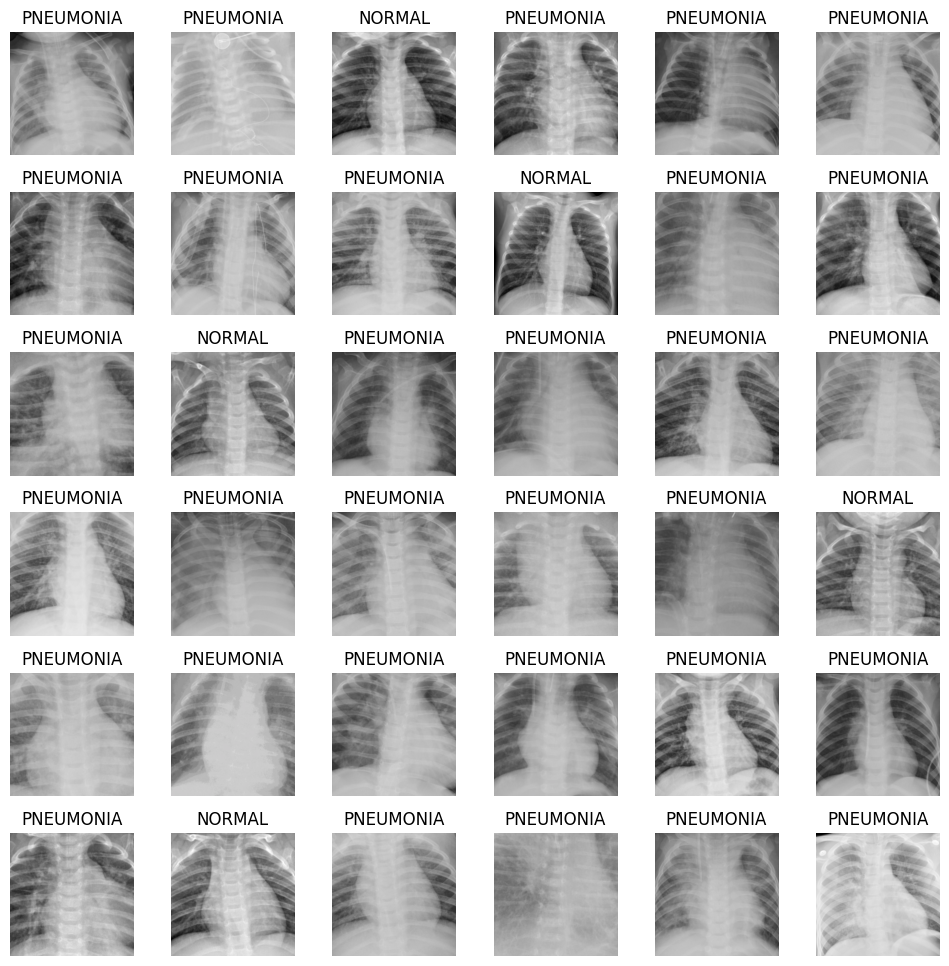

In [18]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [19]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [28]:
model_path = "/content/drive/MyDrive/vgg16-397923af.pth/vgg16-397923af.pth"
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [29]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
for param in model_pre.features.parameters():
    param.required_grad = False

In [31]:
num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1]
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)

print(model_pre)

model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [13]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 1/30


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.1497 Acc: 0.9429
val Loss: 0.1979 Acc: 0.9375
Epoch: 2/30
train Loss: 0.0700 Acc: 0.9760
val Loss: 0.5611 Acc: 0.6875
Epoch: 3/30
train Loss: 0.0607 Acc: 0.9766
val Loss: 0.2180 Acc: 0.9375
Epoch: 4/30
train Loss: 0.0568 Acc: 0.9799
val Loss: 0.2697 Acc: 0.8750
Epoch: 5/30
train Loss: 0.0593 Acc: 0.9781
val Loss: 0.3836 Acc: 0.8750
Epoch: 6/30
train Loss: 0.0565 Acc: 0.9801
val Loss: 0.8261 Acc: 0.5625
Epoch: 7/30
train Loss: 0.0596 Acc: 0.9780
val Loss: 0.3424 Acc: 0.8125
Epoch: 8/30
train Loss: 0.0648 Acc: 0.9764
val Loss: 0.8150 Acc: 0.6875
Epoch: 9/30
train Loss: 0.0675 Acc: 0.9757
val Loss: 0.2880 Acc: 0.8750
Epoch: 10/30
train Loss: 0.0375 Acc: 0.9877
val Loss: 0.4964 Acc: 0.8125
Epoch: 11/30
train Loss: 0.0344 Acc: 0.9887
val Loss: 0.3577 Acc: 0.8750
Epoch: 12/30
train Loss: 0.0323 Acc: 0.9896
val Loss: 0.2994 Acc: 0.9375
Epoch: 13/30
train Loss: 0.0317 Acc: 0.9887
val Loss: 0.3787 Acc: 0.8750
Epoch: 14/30
train Loss: 0.0304 Acc: 0.9896
val Loss: 0.4592 Acc: 0.8125

In [14]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())
            
            #Store model input images
            input_images.append(inputs)
            
            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc


In [15]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

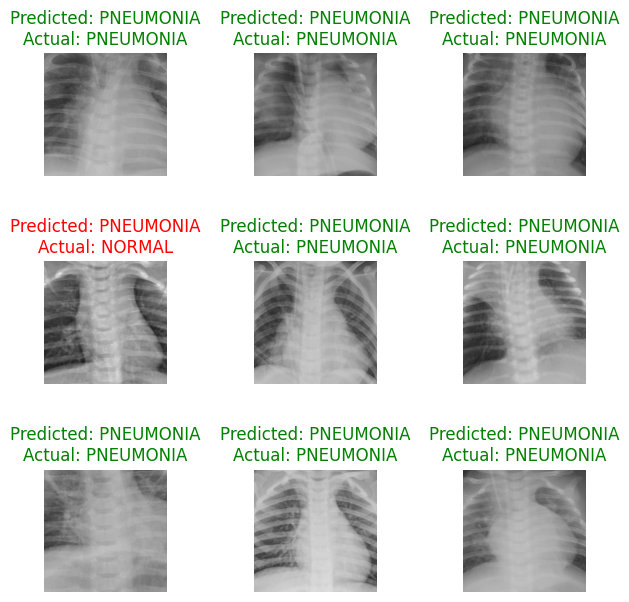

In [16]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


In [17]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)




Total Correct: 524.0 
Total Test Images: 624.0
Test Accuracy:  0.8397435897435898
